# Exoplanet Course at DTU
## Exercise 02 - light curve fitting
In this excercise you will learn how to fit a transit model to a white light curve from JWST

### Import packages
Let's import the packages you need to run the code

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import batman
import emcee

### Load the data
Load the extracted JWST light curves. These have been processed with our own custom built pipeline Frida.

In this example, we will load a transit of the Earth-sized planet TRAPPIST-1c

In [2]:
# Set filename
fn = 'exoplanet_data/TRAPPIST-1c_JWST_PRISM_2023-10-29_prepared_light_curve.h5'
#fn = 'exoplanet_data/WASP-39b_JWST_PRISM_2022-07-10_prepared_light_curve.h5'

# Load H5 file
with h5py.File(fn, 'r') as f:
    # Read all the data into a dictionary
    data = {key: f[key][()] for key in f.keys()}

    # Show the keys
    print('Keys in the data dictionary:')
    print(data.keys())
    



Keys in the data dictionary:
dict_keys(['bjd', 'bjd_binned', 'flux', 'flux_binned', 'flux_err', 'flux_err_binned', 'it_index', 'it_index_non_binned', 'oot_index', 'oot_index_non_binned', 'wavelength', 'white_binned', 'white_err_binned'])


### Data explanation
- bjd - Barycentric Julian Date
- wavelength - Wavelength of the light curves
- flux - Wavelength-dependent light curves 
- flux_err - Wavelength-dependent light curve errors
- it_index_non_binned - Index of datapoints in the light curve during the transit (for non-binned data)
- oot_index_non_binned - Index of datapoints in the light curve outside the transit (for non-binned data)
### Not used for excercises
We will create our own binned data, so we will not be using the following bjd_binned, flux_binned, flux_err_binned, white_binned, white_err_binned

### Data inspection
Let's inspect the data

In [12]:
# Number of observations (integrations)
n_integrations = data['bjd'].shape
print("Number of integrations n_integrations = ", n_integrations)

# Number of wavelength bins
n_wl = data['wavelength'].shape
print("Number of wavelength bins", n_wl)

# Shape of flux
print("flux.shape = ", data['flux'].shape)


# Get the bjd and flux
bjd = data['bjd']
wavelength = data['wavelength']
flux = data['flux']
flux_err = data['flux_err']
oot_index_non_binned = data['oot_index_non_binned']
it_index_non_binned = data['it_index_non_binned']


Number of integrations n_integrations =  (15925,)
Number of wavelength bins (512,)
flux.shape =  (15925, 512)


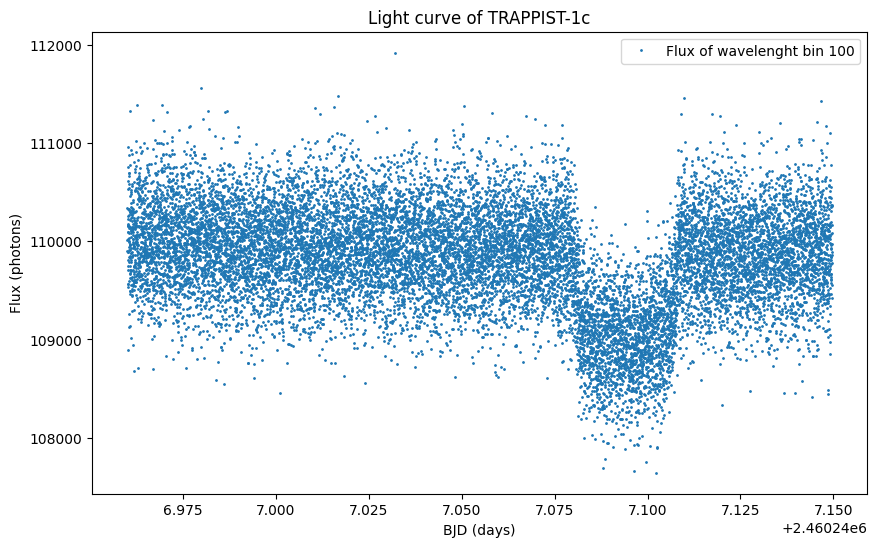

In [4]:
# Plot a specific wavelength bin the white light curve
plt.figure(figsize=(10, 6))
wl_bin = 100
plt.errorbar(bjd, flux[:,wl_bin], label='Flux of wavelenght bin '+ str(wl_bin), fmt='.', capsize=2, markersize=2)
plt.xlabel('BJD (days)')
plt.ylabel('Flux (photons)')
plt.title('Light curve of TRAPPIST-1c')
plt.legend()
plt.show()




### White light curve
Let's make a white light curve, which is essentially all the wavelength bins summed together. In reality, you might want to exclude the wavelengths are the very edge of the detector, where there is almost no or little light present.

In [5]:
# Sum the (nearly) all the wavelength bins
# For PRISM
white_lc_startwlbin =  83                    # First wavelength bin to use for white light curve
white_lc_endwlbin =  339                      # Last wavelength bin to use for white light curve

# Sum the flux over the wavelength bins
white = np.sum(flux[:, white_lc_startwlbin:white_lc_endwlbin], axis=1)
# Calculate the error on the white light curve
white_err = np.sqrt(np.sum(flux_err[:, white_lc_startwlbin:white_lc_endwlbin]**2, axis=1))


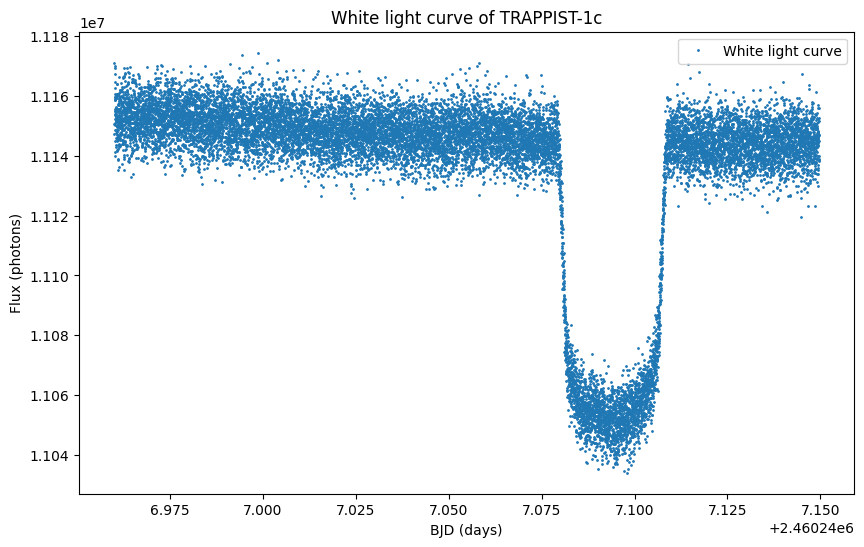

In [6]:
# Plot the white light curve
plt.figure(figsize=(10, 6))
plt.errorbar(bjd, white, label='White light curve', fmt='.', capsize=2, markersize=2)
plt.xlabel('BJD (days)')
plt.ylabel('Flux (photons)')
plt.title('White light curve of TRAPPIST-1c')
plt.legend()
plt.show()

### Normalizing the data
We want to normalize the data so that the out-of-transit data is at approximately at 1. This is done by dividing the data by the median of the out-of-transit data.


In [7]:
def normalize_data(flux, flux_err, oot_index):
    """
    This function normalizes the flux and flux error by dividing by the median of the out-of-transit flux.
    Parameters:
    flux (array): The flux data to be normalized.
    flux_err (array): The flux error data to be normalized.
    oot_index (array): The indices of the out-of-transit data points.
    
    Returns:
    flux (array): The normalized flux data.
    flux_err (array): The normalized flux error data.
    """

    # Calculate the normalization factor
    normfac = np.median(flux[oot_index])

    # Normalize the data
    flux = flux / normfac
    flux_err =  np.abs(flux_err / normfac)

    return flux, flux_err

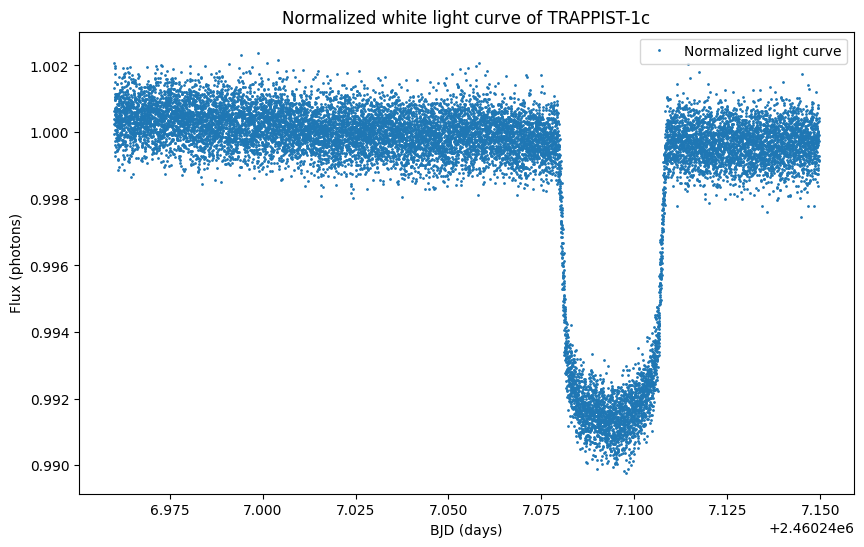

In [8]:
# Normalize the data
white_norm, white_err_norm = normalize_data(white, white_err, oot_index_non_binned)

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.errorbar(bjd, white_norm, label='Normalized light curve', fmt='.', capsize=2, markersize=2)
plt.xlabel('BJD (days)')
plt.ylabel('Flux (photons)')
plt.title('Normalized white light curve of TRAPPIST-1c')
plt.legend()
plt.show()

### Binning the data in time
We have a lot of data points, which will make the fitting process we are about to do slower. We will therefore bin the data in time. We are only doing this to speed up the fitting process.

In [15]:
def bin_data(bjd, flux, flux_err, binning_factor):
    """
    This function bins the data in time.
    
    Parameters:
    bjd (array): Array of Barycentric Julian Dates (BJD)
    flux (array): Array of flux values
    flux_err (array): Array of flux error values
    binning_factor (int): The number of integrations you want to bin together
    
    Returns:
    bjd_binned (array): Array of binned BJD values
    flux_binned (array): Array of binned flux values
    flux_err_binned (array): Array of binned flux error values
    """

    # Get the number of integrations
    n_integrations = bjd.shape[0]

    # Calculate the number of integrations in the binned data
    n_integrations_binned = int(n_integrations/binning_factor)

    # Create arrays to hold results
    bjd_binned = np.empty((n_integrations_binned))
    flux_binned = np.empty((n_integrations_binned))
    flux_err_binned = np.empty((n_integrations_binned))

    # Loop over the integrations
    for i in range(n_integrations_binned):
        # Calcualte mid-flux time
        int_mid_BJD_TDB_avg = np.mean(bjd[i * binning_factor: (i + 1) * binning_factor])

        # Calculate reciprocal_squares (weights)
        weights = 1.0 / (flux_err[i * binning_factor: (i + 1) * binning_factor] ** 2)
        # Calculate flux average over time bin
        flux_avg = np.sum(flux[i * binning_factor: (i + 1) * binning_factor] * weights) / np.sum(weights)
        # Calculate the errors over time bin
        flux_err_avg = 1.0 / np.sqrt(np.sum(weights))

        # Put the values into the arrays
        bjd_binned[i] = int_mid_BJD_TDB_avg
        flux_binned[i] = flux_avg
        flux_err_binned[i] = flux_err_avg

    # Return the binned data
    return bjd_binned, flux_binned, flux_err_binned

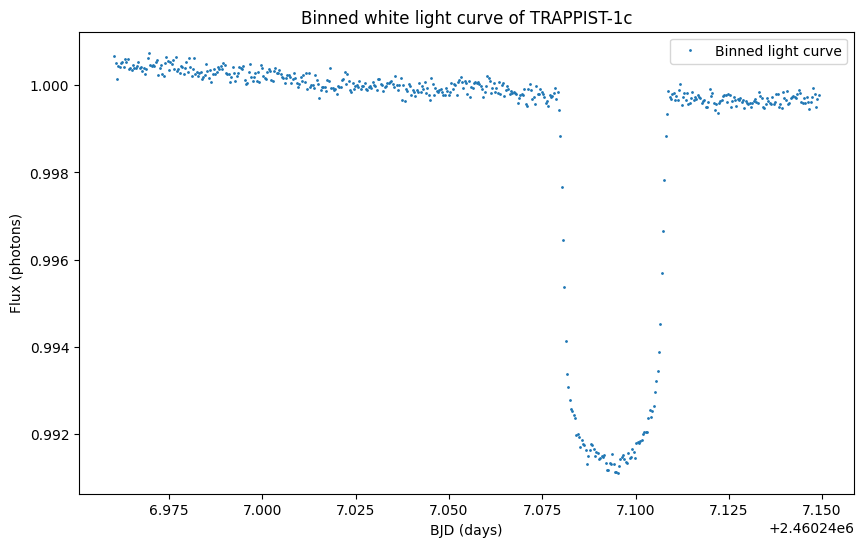

In [10]:
# Bin the data
binning_factor = 30
bjd_binned, white_binned, white_err_binned = bin_data(bjd, white_norm, white_err_norm, binning_factor)

# Plot the binned data
plt.figure(figsize=(10, 6))
plt.errorbar(bjd_binned, white_binned, label='Binned light curve', fmt='.', capsize=2, markersize=2)
plt.xlabel('BJD (days)')
plt.ylabel('Flux (photons)')
plt.title('Binned white light curve of TRAPPIST-1c')
plt.legend()
plt.show()


### White light curve fitting
In the following, we will fir a transit model and a linear systematics model to the white light curve. This will give us the transit parameters and the systematics parameters. We will use the transit parameters we find in the white light curve fit when we fit the wavelength-dependent light curves in the next excercise.

We will fit the data with an MCMC algorithm. For this, we will use the emcee package. 

Let's first define the transit model.

In [16]:
light_curve_params_to_fit = ['t0', 'period', 'a', 'inc', 'rp']


In [17]:
def calc_light_curve_model(bjd, vars):
    """
    Calculate the light curve model using the batman package.

    Parameters:
    bjd (array-like): Array of Barycentric Julian Dates (BJD) at which to calculate the light curve.
    vars (array-like): Array of parameters for the transit model. The parameters should be in the following order:
        - t0: Time of inferior conjunction (in BJD)
        - period: Orbital period (in days)
        - a: Semi-major axis (in units of stellar radii)
        - inc: Orbital inclination (in degrees)
        - rp: Planet radius (in units of stellar radii)
        - u1: Limb darkening coefficient u1
        - u2: Limb darkening coefficient u2

    Returns:
    lc_flux (array-like): The calculated light curve flux values.
    """

    # Initialize the batman parameters
    batmanparams = batman.TransitParams()

    # Orbital period (in days)
    batmanparams.per = vars[light_curve_params_to_fit.index('period')]

    # Semi-major axis (in units of stellar radii)
    batmanparams.a = vars[light_curve_params_to_fit.index('a')]  

    # Orbital inclination (in degrees)
    batmanparams.inc = vars[light_curve_params_to_fit.index('inc')]  

    # Planet radius (in units of stellar radii)
    batmanparams.rp = vars[light_curve_params_to_fit.index('rp')] 

    batmanparams.ecc = 0  # eccentricity
    batmanparams.w = 90  # longitude of periastron (in degrees)

    u1 = vars[light_curve_params_to_fit.index('u1')]  # u1
    u2 = vars[light_curve_params_to_fit.index('u2')]  # u2
    batmanparams.u = [u1, u2]
    batmanparams.limb_dark = "quadratic"

    m = batman.TransitModel(batmanparams, np.asarray(bjd), transittype='primary')
    lc_flux = m.light_curve(batmanparams)

    # Return
    return lc_flux